# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

In [1]:
data_dir = './data'

import sys
sys.path.append('../auxiliary')
import helper_face_gen as helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

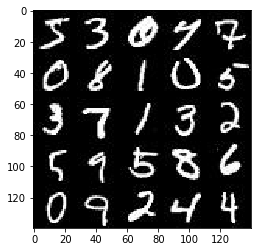

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

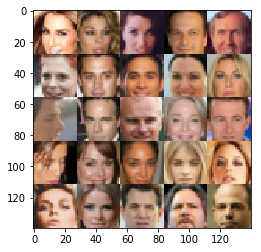

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests_face_gen as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)) 
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
       
    return input_real, input_z, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
# function that applies a leaky ReLU to a layer
def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)

# weight initializer for the discriminator and generator
initializer = tf.contrib.layers.xavier_initializer()

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # using a DCGAN architecture
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, padding='same', kernel_initializer=initializer)
        relu1 = leaky_relu(x1)
        #28x28x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, 2, padding='same', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        #14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, 2, padding='same',kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 =leaky_relu(bn3)
        #7x7x256

        flat = tf.reshape(relu3, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, padding='same', kernel_initializer=initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(tf.nn.dropout(x2, keep_prob=.5))
        #7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, padding='same', kernel_initializer=initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        #14x14x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, padding='same', kernel_initializer=initializer)
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing_factor = .9
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing_factor))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    # total discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(*data_shape[1:], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # putting real images into the [-1, 1] range
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if step % 10 == 0:
                
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}, step {}...".format(epoch_i + 1, epoch_count, step),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))    
            
                if step % 100 == 0:
                    show_generator_output(sess, 15, input_z, data_shape[-1], data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 10... Discriminator Loss: 3.5194... Generator Loss: 0.0334
Epoch 1/2, step 20... Discriminator Loss: 2.6992... Generator Loss: 0.0779
Epoch 1/2, step 30... Discriminator Loss: 0.3774... Generator Loss: 1.4605
Epoch 1/2, step 40... Discriminator Loss: 0.3984... Generator Loss: 1.5446
Epoch 1/2, step 50... Discriminator Loss: 1.1759... Generator Loss: 0.4423
Epoch 1/2, step 60... Discriminator Loss: 2.1630... Generator Loss: 0.1492
Epoch 1/2, step 70... Discriminator Loss: 0.5280... Generator Loss: 1.1192
Epoch 1/2, step 80... Discriminator Loss: 1.2258... Generator Loss: 0.4370
Epoch 1/2, step 90... Discriminator Loss: 0.4822... Generator Loss: 2.3974
Epoch 1/2, step 100... Discriminator Loss: 0.5368... Generator Loss: 3.0757


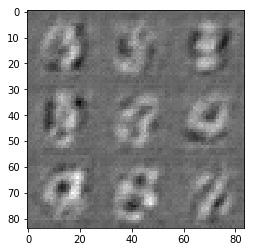

Epoch 1/2, step 110... Discriminator Loss: 1.7604... Generator Loss: 4.7534
Epoch 1/2, step 120... Discriminator Loss: 0.4748... Generator Loss: 2.2521
Epoch 1/2, step 130... Discriminator Loss: 0.3851... Generator Loss: 1.6236
Epoch 1/2, step 140... Discriminator Loss: 1.0653... Generator Loss: 0.4811
Epoch 1/2, step 150... Discriminator Loss: 0.9191... Generator Loss: 0.6173
Epoch 1/2, step 160... Discriminator Loss: 0.6298... Generator Loss: 0.9027
Epoch 1/2, step 170... Discriminator Loss: 2.7369... Generator Loss: 0.1108
Epoch 1/2, step 180... Discriminator Loss: 0.5463... Generator Loss: 1.1746
Epoch 1/2, step 190... Discriminator Loss: 0.3592... Generator Loss: 1.9805
Epoch 1/2, step 200... Discriminator Loss: 0.4294... Generator Loss: 2.5050


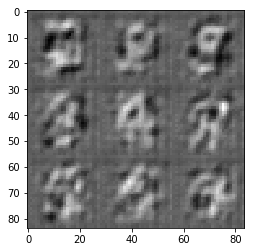

Epoch 1/2, step 210... Discriminator Loss: 0.6904... Generator Loss: 2.9266
Epoch 1/2, step 220... Discriminator Loss: 0.4870... Generator Loss: 1.3237
Epoch 1/2, step 230... Discriminator Loss: 1.4014... Generator Loss: 0.3366
Epoch 1/2, step 240... Discriminator Loss: 0.5642... Generator Loss: 1.0759
Epoch 1/2, step 250... Discriminator Loss: 0.4281... Generator Loss: 1.5951
Epoch 1/2, step 260... Discriminator Loss: 0.6093... Generator Loss: 3.1476
Epoch 1/2, step 270... Discriminator Loss: 0.8515... Generator Loss: 3.4778
Epoch 1/2, step 280... Discriminator Loss: 0.4676... Generator Loss: 1.7908
Epoch 1/2, step 290... Discriminator Loss: 0.5338... Generator Loss: 1.1043
Epoch 1/2, step 300... Discriminator Loss: 0.4743... Generator Loss: 1.2418


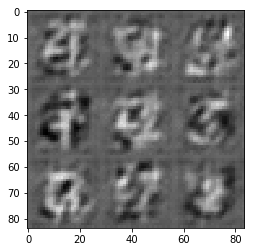

Epoch 1/2, step 310... Discriminator Loss: 1.5221... Generator Loss: 0.3406
Epoch 1/2, step 320... Discriminator Loss: 0.5161... Generator Loss: 1.3900
Epoch 1/2, step 330... Discriminator Loss: 0.8463... Generator Loss: 0.6849
Epoch 1/2, step 340... Discriminator Loss: 1.0144... Generator Loss: 0.5979
Epoch 1/2, step 350... Discriminator Loss: 0.4235... Generator Loss: 1.6372
Epoch 1/2, step 360... Discriminator Loss: 0.7394... Generator Loss: 0.7926
Epoch 1/2, step 370... Discriminator Loss: 0.3563... Generator Loss: 2.0942
Epoch 1/2, step 380... Discriminator Loss: 0.3754... Generator Loss: 1.9304
Epoch 1/2, step 390... Discriminator Loss: 0.8261... Generator Loss: 0.7173
Epoch 1/2, step 400... Discriminator Loss: 0.8953... Generator Loss: 0.6852


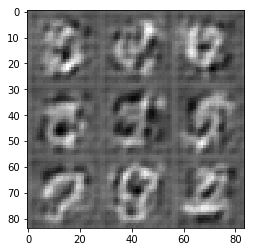

Epoch 1/2, step 410... Discriminator Loss: 0.5327... Generator Loss: 1.4958
Epoch 1/2, step 420... Discriminator Loss: 0.5819... Generator Loss: 1.0565
Epoch 1/2, step 430... Discriminator Loss: 0.5155... Generator Loss: 1.4940
Epoch 1/2, step 440... Discriminator Loss: 1.6928... Generator Loss: 4.1455
Epoch 1/2, step 450... Discriminator Loss: 0.5553... Generator Loss: 1.6420
Epoch 1/2, step 460... Discriminator Loss: 0.9395... Generator Loss: 2.7882
Epoch 2/2, step 10... Discriminator Loss: 0.5070... Generator Loss: 1.5477
Epoch 2/2, step 20... Discriminator Loss: 1.0397... Generator Loss: 2.7489
Epoch 2/2, step 30... Discriminator Loss: 0.7258... Generator Loss: 2.3535
Epoch 2/2, step 40... Discriminator Loss: 0.5435... Generator Loss: 1.1744
Epoch 2/2, step 50... Discriminator Loss: 0.5601... Generator Loss: 1.1030
Epoch 2/2, step 60... Discriminator Loss: 1.6524... Generator Loss: 0.2669
Epoch 2/2, step 70... Discriminator Loss: 0.8025... Generator Loss: 0.7735
Epoch 2/2, step 80.

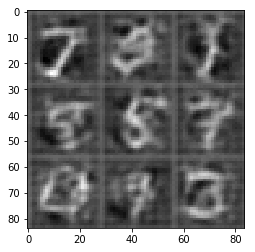

Epoch 2/2, step 110... Discriminator Loss: 0.6123... Generator Loss: 1.6719
Epoch 2/2, step 120... Discriminator Loss: 0.5868... Generator Loss: 1.1399
Epoch 2/2, step 130... Discriminator Loss: 1.0169... Generator Loss: 0.5743
Epoch 2/2, step 140... Discriminator Loss: 1.3039... Generator Loss: 0.4839
Epoch 2/2, step 150... Discriminator Loss: 1.5087... Generator Loss: 0.3121
Epoch 2/2, step 160... Discriminator Loss: 1.5145... Generator Loss: 0.3014
Epoch 2/2, step 170... Discriminator Loss: 1.2843... Generator Loss: 0.4938
Epoch 2/2, step 180... Discriminator Loss: 0.6774... Generator Loss: 0.9758
Epoch 2/2, step 190... Discriminator Loss: 0.5755... Generator Loss: 1.1411
Epoch 2/2, step 200... Discriminator Loss: 1.0676... Generator Loss: 0.5343


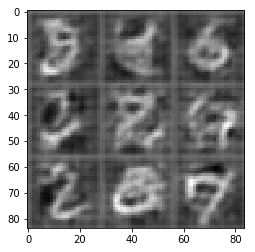

Epoch 2/2, step 210... Discriminator Loss: 0.6060... Generator Loss: 1.0444
Epoch 2/2, step 220... Discriminator Loss: 5.6929... Generator Loss: 0.0054
Epoch 2/2, step 230... Discriminator Loss: 1.4217... Generator Loss: 0.3384
Epoch 2/2, step 240... Discriminator Loss: 1.4186... Generator Loss: 0.3608
Epoch 2/2, step 250... Discriminator Loss: 0.7008... Generator Loss: 1.0363
Epoch 2/2, step 260... Discriminator Loss: 0.5789... Generator Loss: 1.0499
Epoch 2/2, step 270... Discriminator Loss: 0.5740... Generator Loss: 1.1249
Epoch 2/2, step 280... Discriminator Loss: 0.6586... Generator Loss: 0.9934
Epoch 2/2, step 290... Discriminator Loss: 0.6452... Generator Loss: 0.9543
Epoch 2/2, step 300... Discriminator Loss: 1.3990... Generator Loss: 0.3535


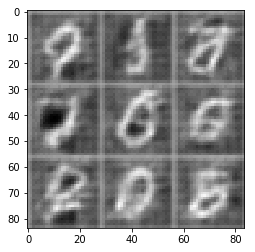

Epoch 2/2, step 310... Discriminator Loss: 1.6375... Generator Loss: 2.9389
Epoch 2/2, step 320... Discriminator Loss: 0.6789... Generator Loss: 1.3063
Epoch 2/2, step 330... Discriminator Loss: 0.7498... Generator Loss: 0.9593
Epoch 2/2, step 340... Discriminator Loss: 0.7983... Generator Loss: 1.1503
Epoch 2/2, step 350... Discriminator Loss: 0.6552... Generator Loss: 1.0066
Epoch 2/2, step 360... Discriminator Loss: 1.8740... Generator Loss: 2.9779
Epoch 2/2, step 370... Discriminator Loss: 0.9808... Generator Loss: 2.1688
Epoch 2/2, step 380... Discriminator Loss: 0.6320... Generator Loss: 1.0593
Epoch 2/2, step 390... Discriminator Loss: 0.6310... Generator Loss: 1.1756
Epoch 2/2, step 400... Discriminator Loss: 0.7541... Generator Loss: 0.8467


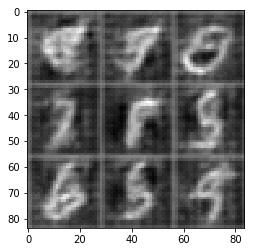

Epoch 2/2, step 410... Discriminator Loss: 0.5494... Generator Loss: 1.1589
Epoch 2/2, step 420... Discriminator Loss: 0.7326... Generator Loss: 0.8195
Epoch 2/2, step 430... Discriminator Loss: 1.9948... Generator Loss: 0.2470
Epoch 2/2, step 440... Discriminator Loss: 2.4956... Generator Loss: 0.1254
Epoch 2/2, step 450... Discriminator Loss: 1.7423... Generator Loss: 0.2488
Epoch 2/2, step 460... Discriminator Loss: 1.3454... Generator Loss: 0.4092


In [21]:
batch_size = 128
z_dim = 100
learning_rate = .002
beta1 = .1
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, step 10... Discriminator Loss: 5.4492... Generator Loss: 0.0481
Epoch 1/1, step 20... Discriminator Loss: 3.8746... Generator Loss: 1.2856
Epoch 1/1, step 30... Discriminator Loss: 2.7146... Generator Loss: 1.0569
Epoch 1/1, step 40... Discriminator Loss: 2.4857... Generator Loss: 0.7117
Epoch 1/1, step 50... Discriminator Loss: 3.3630... Generator Loss: 1.2426
Epoch 1/1, step 60... Discriminator Loss: 2.1519... Generator Loss: 0.8500
Epoch 1/1, step 70... Discriminator Loss: 1.7321... Generator Loss: 0.4138
Epoch 1/1, step 80... Discriminator Loss: 2.8256... Generator Loss: 0.1491
Epoch 1/1, step 90... Discriminator Loss: 2.2398... Generator Loss: 0.2021
Epoch 1/1, step 100... Discriminator Loss: 1.6108... Generator Loss: 0.4262


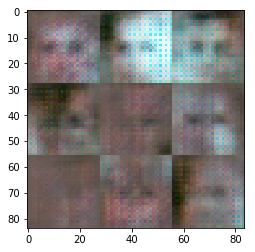

Epoch 1/1, step 110... Discriminator Loss: 1.8027... Generator Loss: 0.3384
Epoch 1/1, step 120... Discriminator Loss: 1.4643... Generator Loss: 0.8188
Epoch 1/1, step 130... Discriminator Loss: 1.5512... Generator Loss: 0.4419
Epoch 1/1, step 140... Discriminator Loss: 2.1233... Generator Loss: 0.7121
Epoch 1/1, step 150... Discriminator Loss: 2.7788... Generator Loss: 0.2110
Epoch 1/1, step 160... Discriminator Loss: 1.9475... Generator Loss: 0.5874
Epoch 1/1, step 170... Discriminator Loss: 1.4926... Generator Loss: 0.5356
Epoch 1/1, step 180... Discriminator Loss: 1.5304... Generator Loss: 0.7082
Epoch 1/1, step 190... Discriminator Loss: 1.5377... Generator Loss: 0.7493
Epoch 1/1, step 200... Discriminator Loss: 1.4016... Generator Loss: 0.5946


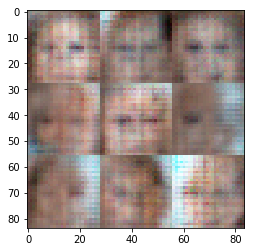

Epoch 1/1, step 210... Discriminator Loss: 1.5005... Generator Loss: 0.8693
Epoch 1/1, step 220... Discriminator Loss: 2.1426... Generator Loss: 0.6846
Epoch 1/1, step 230... Discriminator Loss: 1.5810... Generator Loss: 0.8447
Epoch 1/1, step 240... Discriminator Loss: 1.4400... Generator Loss: 0.7672
Epoch 1/1, step 250... Discriminator Loss: 1.4075... Generator Loss: 0.7273
Epoch 1/1, step 260... Discriminator Loss: 1.6237... Generator Loss: 0.7256
Epoch 1/1, step 270... Discriminator Loss: 1.5430... Generator Loss: 0.8414
Epoch 1/1, step 280... Discriminator Loss: 1.4234... Generator Loss: 0.7070
Epoch 1/1, step 290... Discriminator Loss: 4.6522... Generator Loss: 0.1821
Epoch 1/1, step 300... Discriminator Loss: 2.0513... Generator Loss: 0.3371


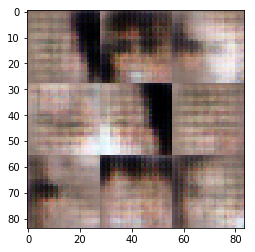

Epoch 1/1, step 310... Discriminator Loss: 1.6791... Generator Loss: 0.3813
Epoch 1/1, step 320... Discriminator Loss: 1.5469... Generator Loss: 0.5153
Epoch 1/1, step 330... Discriminator Loss: 1.4754... Generator Loss: 0.5719
Epoch 1/1, step 340... Discriminator Loss: 1.4355... Generator Loss: 0.6542
Epoch 1/1, step 350... Discriminator Loss: 1.4363... Generator Loss: 0.7132
Epoch 1/1, step 360... Discriminator Loss: 1.3909... Generator Loss: 0.6715
Epoch 1/1, step 370... Discriminator Loss: 1.5043... Generator Loss: 0.7170
Epoch 1/1, step 380... Discriminator Loss: 1.4099... Generator Loss: 0.7601
Epoch 1/1, step 390... Discriminator Loss: 1.3856... Generator Loss: 0.6164
Epoch 1/1, step 400... Discriminator Loss: 2.6513... Generator Loss: 0.2316


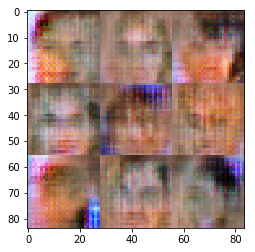

Epoch 1/1, step 410... Discriminator Loss: 1.5509... Generator Loss: 0.7862
Epoch 1/1, step 420... Discriminator Loss: 1.5295... Generator Loss: 0.8590
Epoch 1/1, step 430... Discriminator Loss: 1.4789... Generator Loss: 0.6980
Epoch 1/1, step 440... Discriminator Loss: 1.5214... Generator Loss: 0.7803
Epoch 1/1, step 450... Discriminator Loss: 1.4097... Generator Loss: 0.6849
Epoch 1/1, step 460... Discriminator Loss: 1.4650... Generator Loss: 0.5707
Epoch 1/1, step 470... Discriminator Loss: 1.3709... Generator Loss: 0.6599
Epoch 1/1, step 480... Discriminator Loss: 1.4158... Generator Loss: 0.6368
Epoch 1/1, step 490... Discriminator Loss: 1.4157... Generator Loss: 0.7228
Epoch 1/1, step 500... Discriminator Loss: 1.4501... Generator Loss: 0.5772


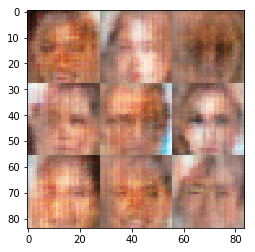

Epoch 1/1, step 510... Discriminator Loss: 1.3740... Generator Loss: 0.6984
Epoch 1/1, step 520... Discriminator Loss: 1.4308... Generator Loss: 0.8132
Epoch 1/1, step 530... Discriminator Loss: 1.4114... Generator Loss: 0.6267
Epoch 1/1, step 540... Discriminator Loss: 1.3877... Generator Loss: 0.7390
Epoch 1/1, step 550... Discriminator Loss: 1.4093... Generator Loss: 0.5992
Epoch 1/1, step 560... Discriminator Loss: 1.5117... Generator Loss: 0.5443
Epoch 1/1, step 570... Discriminator Loss: 1.4029... Generator Loss: 0.7148
Epoch 1/1, step 580... Discriminator Loss: 1.3693... Generator Loss: 0.6702
Epoch 1/1, step 590... Discriminator Loss: 1.4668... Generator Loss: 0.5832
Epoch 1/1, step 600... Discriminator Loss: 1.3983... Generator Loss: 0.6181


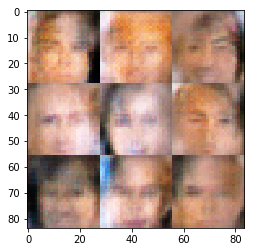

Epoch 1/1, step 610... Discriminator Loss: 1.4019... Generator Loss: 0.7552
Epoch 1/1, step 620... Discriminator Loss: 1.4758... Generator Loss: 0.6280
Epoch 1/1, step 630... Discriminator Loss: 1.4388... Generator Loss: 0.7233
Epoch 1/1, step 640... Discriminator Loss: 1.3975... Generator Loss: 0.6756
Epoch 1/1, step 650... Discriminator Loss: 1.4696... Generator Loss: 0.8646
Epoch 1/1, step 660... Discriminator Loss: 1.4398... Generator Loss: 0.6936
Epoch 1/1, step 670... Discriminator Loss: 1.4015... Generator Loss: 0.6499
Epoch 1/1, step 680... Discriminator Loss: 1.3842... Generator Loss: 0.6570
Epoch 1/1, step 690... Discriminator Loss: 1.4494... Generator Loss: 0.5406
Epoch 1/1, step 700... Discriminator Loss: 1.3790... Generator Loss: 0.6952


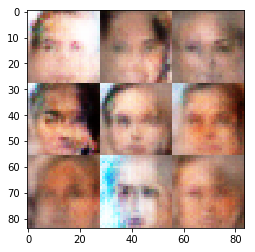

Epoch 1/1, step 710... Discriminator Loss: 1.4034... Generator Loss: 0.7201
Epoch 1/1, step 720... Discriminator Loss: 1.4358... Generator Loss: 0.6568
Epoch 1/1, step 730... Discriminator Loss: 1.3711... Generator Loss: 0.6278
Epoch 1/1, step 740... Discriminator Loss: 1.4434... Generator Loss: 0.7430
Epoch 1/1, step 750... Discriminator Loss: 1.3870... Generator Loss: 0.6396
Epoch 1/1, step 760... Discriminator Loss: 1.4544... Generator Loss: 0.8141
Epoch 1/1, step 770... Discriminator Loss: 1.3998... Generator Loss: 0.6685
Epoch 1/1, step 780... Discriminator Loss: 1.4759... Generator Loss: 0.7635
Epoch 1/1, step 790... Discriminator Loss: 1.3948... Generator Loss: 0.6341
Epoch 1/1, step 800... Discriminator Loss: 1.3909... Generator Loss: 0.5990


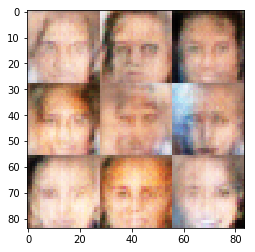

Epoch 1/1, step 810... Discriminator Loss: 1.4043... Generator Loss: 0.6577
Epoch 1/1, step 820... Discriminator Loss: 1.5944... Generator Loss: 0.8581
Epoch 1/1, step 830... Discriminator Loss: 1.4066... Generator Loss: 0.6964
Epoch 1/1, step 840... Discriminator Loss: 3.2165... Generator Loss: 0.8815
Epoch 1/1, step 850... Discriminator Loss: 1.4804... Generator Loss: 0.6567
Epoch 1/1, step 860... Discriminator Loss: 1.4846... Generator Loss: 0.6384
Epoch 1/1, step 870... Discriminator Loss: 1.4217... Generator Loss: 0.5723
Epoch 1/1, step 880... Discriminator Loss: 1.4302... Generator Loss: 0.5715
Epoch 1/1, step 890... Discriminator Loss: 1.4210... Generator Loss: 0.6011
Epoch 1/1, step 900... Discriminator Loss: 1.4058... Generator Loss: 0.5933


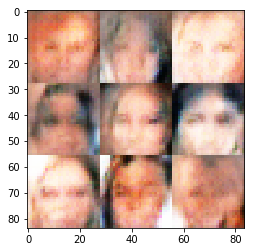

Epoch 1/1, step 910... Discriminator Loss: 1.3953... Generator Loss: 0.7215
Epoch 1/1, step 920... Discriminator Loss: 1.3807... Generator Loss: 0.6609
Epoch 1/1, step 930... Discriminator Loss: 1.4126... Generator Loss: 0.6688
Epoch 1/1, step 940... Discriminator Loss: 1.5339... Generator Loss: 0.4616
Epoch 1/1, step 950... Discriminator Loss: 1.3912... Generator Loss: 0.6896
Epoch 1/1, step 960... Discriminator Loss: 1.3938... Generator Loss: 0.6450
Epoch 1/1, step 970... Discriminator Loss: 1.3701... Generator Loss: 0.6767
Epoch 1/1, step 980... Discriminator Loss: 1.4274... Generator Loss: 0.6701
Epoch 1/1, step 990... Discriminator Loss: 1.4217... Generator Loss: 0.7124
Epoch 1/1, step 1000... Discriminator Loss: 1.3777... Generator Loss: 0.6877


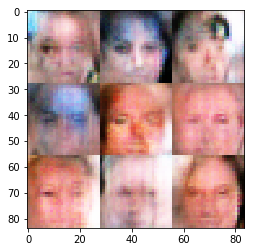

Epoch 1/1, step 1010... Discriminator Loss: 1.4020... Generator Loss: 0.6133
Epoch 1/1, step 1020... Discriminator Loss: 1.4142... Generator Loss: 0.6829
Epoch 1/1, step 1030... Discriminator Loss: 1.3704... Generator Loss: 0.6687
Epoch 1/1, step 1040... Discriminator Loss: 1.3801... Generator Loss: 0.6780
Epoch 1/1, step 1050... Discriminator Loss: 1.4049... Generator Loss: 0.5978
Epoch 1/1, step 1060... Discriminator Loss: 1.4335... Generator Loss: 0.6919
Epoch 1/1, step 1070... Discriminator Loss: 1.3837... Generator Loss: 0.6848
Epoch 1/1, step 1080... Discriminator Loss: 1.3674... Generator Loss: 0.5954
Epoch 1/1, step 1090... Discriminator Loss: 1.4605... Generator Loss: 0.4783
Epoch 1/1, step 1100... Discriminator Loss: 1.3665... Generator Loss: 0.7397


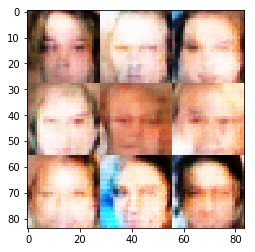

Epoch 1/1, step 1110... Discriminator Loss: 1.4753... Generator Loss: 0.8670
Epoch 1/1, step 1120... Discriminator Loss: 1.4793... Generator Loss: 0.5746
Epoch 1/1, step 1130... Discriminator Loss: 1.4850... Generator Loss: 0.5207
Epoch 1/1, step 1140... Discriminator Loss: 1.4022... Generator Loss: 0.7689
Epoch 1/1, step 1150... Discriminator Loss: 1.4349... Generator Loss: 0.6326
Epoch 1/1, step 1160... Discriminator Loss: 1.4106... Generator Loss: 0.5586
Epoch 1/1, step 1170... Discriminator Loss: 1.3926... Generator Loss: 0.7554
Epoch 1/1, step 1180... Discriminator Loss: 1.4061... Generator Loss: 0.5786
Epoch 1/1, step 1190... Discriminator Loss: 1.4764... Generator Loss: 0.8842
Epoch 1/1, step 1200... Discriminator Loss: 1.4071... Generator Loss: 0.7446


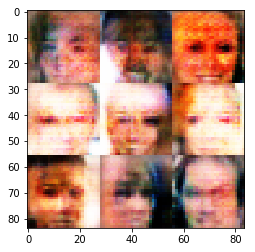

Epoch 1/1, step 1210... Discriminator Loss: 1.4200... Generator Loss: 0.6323
Epoch 1/1, step 1220... Discriminator Loss: 1.3988... Generator Loss: 0.7170
Epoch 1/1, step 1230... Discriminator Loss: 1.3984... Generator Loss: 0.6833
Epoch 1/1, step 1240... Discriminator Loss: 1.3897... Generator Loss: 0.6646
Epoch 1/1, step 1250... Discriminator Loss: 1.3750... Generator Loss: 0.6577
Epoch 1/1, step 1260... Discriminator Loss: 1.3716... Generator Loss: 0.6994
Epoch 1/1, step 1270... Discriminator Loss: 1.4764... Generator Loss: 0.4879
Epoch 1/1, step 1280... Discriminator Loss: 1.4146... Generator Loss: 0.6133
Epoch 1/1, step 1290... Discriminator Loss: 1.3895... Generator Loss: 0.7446
Epoch 1/1, step 1300... Discriminator Loss: 1.5142... Generator Loss: 0.6975


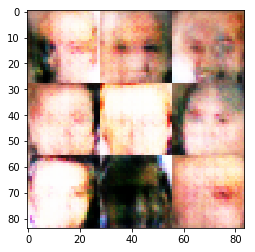

Epoch 1/1, step 1310... Discriminator Loss: 1.4976... Generator Loss: 0.6248
Epoch 1/1, step 1320... Discriminator Loss: 1.3715... Generator Loss: 0.6896
Epoch 1/1, step 1330... Discriminator Loss: 1.4016... Generator Loss: 0.6219
Epoch 1/1, step 1340... Discriminator Loss: 1.3604... Generator Loss: 0.6833
Epoch 1/1, step 1350... Discriminator Loss: 1.3958... Generator Loss: 0.8274
Epoch 1/1, step 1360... Discriminator Loss: 1.4221... Generator Loss: 0.6428
Epoch 1/1, step 1370... Discriminator Loss: 1.4122... Generator Loss: 0.6985
Epoch 1/1, step 1380... Discriminator Loss: 1.4878... Generator Loss: 0.6174
Epoch 1/1, step 1390... Discriminator Loss: 1.4216... Generator Loss: 0.7324
Epoch 1/1, step 1400... Discriminator Loss: 1.4202... Generator Loss: 0.6865


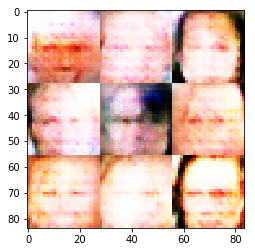

Epoch 1/1, step 1410... Discriminator Loss: 1.4229... Generator Loss: 0.6465
Epoch 1/1, step 1420... Discriminator Loss: 1.3906... Generator Loss: 0.7210
Epoch 1/1, step 1430... Discriminator Loss: 1.3982... Generator Loss: 0.7730
Epoch 1/1, step 1440... Discriminator Loss: 1.3968... Generator Loss: 0.7245
Epoch 1/1, step 1450... Discriminator Loss: 1.4087... Generator Loss: 0.6439
Epoch 1/1, step 1460... Discriminator Loss: 1.3966... Generator Loss: 0.6693
Epoch 1/1, step 1470... Discriminator Loss: 1.3947... Generator Loss: 0.7115
Epoch 1/1, step 1480... Discriminator Loss: 1.4097... Generator Loss: 0.8247
Epoch 1/1, step 1490... Discriminator Loss: 1.3378... Generator Loss: 0.7123
Epoch 1/1, step 1500... Discriminator Loss: 1.3016... Generator Loss: 0.7239


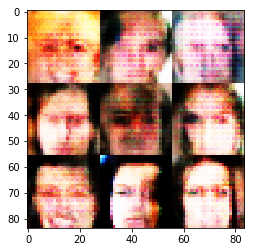

Epoch 1/1, step 1510... Discriminator Loss: 1.5806... Generator Loss: 0.4493
Epoch 1/1, step 1520... Discriminator Loss: 1.4634... Generator Loss: 0.6439
Epoch 1/1, step 1530... Discriminator Loss: 1.4633... Generator Loss: 0.6474
Epoch 1/1, step 1540... Discriminator Loss: 1.4371... Generator Loss: 0.6486
Epoch 1/1, step 1550... Discriminator Loss: 1.4107... Generator Loss: 0.7095
Epoch 1/1, step 1560... Discriminator Loss: 1.4347... Generator Loss: 0.7130
Epoch 1/1, step 1570... Discriminator Loss: 1.3977... Generator Loss: 0.6448
Epoch 1/1, step 1580... Discriminator Loss: 1.4141... Generator Loss: 0.5992


In [31]:
batch_size = 128
z_dim = 100
learning_rate = .002
beta1 = .1
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)